In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

X_train = np.load('./X_train_G.npy')
y_train = np.load('./y_train_G.npy')
X_test = np.load('./X_test_G.npy')
y_test = np.load('./y_test_G.npy')
X_val = np.load('./X_val_G.npy')
y_val = np.load('./y_val_G.npy')
Features = []
Score = []
from operator import attrgetter
from sklearn.utils import safe_sqr
from sklearn.inspection import permutation_importance



def get_feature_importances(estimator, features, transform_func=None, norm_order=1):

        # Get the individual base estimators from the fitted regression chain

        # A place to store the feature importances for each estimator

        # Iterate through the fitted estimators
        #for i in range(len(all_estimators)):

            # This is modified from the SKLearn > Feature Selection > _base.py file
        if hasattr(estimator, 'coef_'):
            print('yay!')
            getter = attrgetter('coef_')
            importances = getter(estimator)

        elif hasattr(estimator, 'feature_importances_'):
            print('yay!')
            getter = attrgetter('feature_importances_')
            importances = getter(estimator)

        else:
            print('DOH!')
            r = permutation_importance(estimator,X_val[:2000][:, features],y_val[:2000], n_repeats = 1)
            Features.append(features)
            Score.append(estimator.score(X_val[:2000][:, features],y_val[:2000]))
            importances = r.importances_mean

        if transform_func is None:
            return importances
        elif transform_func == "norm":
            if importances.ndim == 1:
                importances = np.abs(importances)
            else:
                importances = np.linalg.norm(importances, axis=0,
                                             ord=norm_order)
        elif transform_func == "square":
            if importances.ndim == 1:
                importances = safe_sqr(importances)
            else:
                importances = safe_sqr(importances).sum(axis=0)
        else:
            raise ValueError("Valid values for `self.transform_func` are " +
                             "None, 'norm' and 'square'. Those two " +
                             "transformation are only supported now")

        return importances

In [17]:
from numbers import Integral

import numpy as np
from joblib import effective_n_jobs

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone, is_classifier
from sklearn.metrics import check_scoring
from sklearn.model_selection import check_cv
from sklearn.model_selection._validation import _score
from sklearn.utils._param_validation import HasMethods, Interval
from sklearn.utils._tags import _safe_tags
from sklearn.utils.metaestimators import _safe_split, available_if
from sklearn.utils.parallel import Parallel, delayed
from sklearn.utils.validation import check_is_fitted


def _rfe_single_fit(rfe, estimator, X, y, train, test, scorer):
    """
    Return the score for a fit across one fold.
    """
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, y_test = _safe_split(estimator, X, y, test, train)
    return rfe._fit(
        X_train,
        y_train,
        lambda estimator, features: _score(
            estimator, X_test[:, features], y_test, scorer
        ),
    ).scores_


def _estimator_has(attr):
    """Check if we can delegate a method to the underlying estimator.
    First, we check the first fitted estimator if available, otherwise we
    check the unfitted estimator.
    """
    return lambda self: (
        hasattr(self.estimator_, attr)
        if hasattr(self, "estimator_")
        else hasattr(self.estimator, attr)
    )


class RFE1(MetaEstimatorMixin, BaseEstimator):
    """Feature ranking with recursive feature elimination.
    Given an external estimator that assigns weights to features (e.g., the
    coefficients of a linear model), the goal of recursive feature elimination
    (RFE) is to select features by recursively considering smaller and smaller
    sets of features. First, the estimator is trained on the initial set of
    features and the importance of each feature is obtained either through
    any specific attribute or callable.
    Then, the least important features are pruned from current set of features.
    That procedure is recursively repeated on the pruned set until the desired
    number of features to select is eventually reached.
    Read more in the :ref:`User Guide <rfe>`.
    Parameters
    ----------
    estimator : ``Estimator`` instance
        A supervised learning estimator with a ``fit`` method that provides
        information about feature importance
        (e.g. `coef_`, `feature_importances_`).
    n_features_to_select : int or float, default=None
        The number of features to select. If `None`, half of the features are
        selected. If integer, the parameter is the absolute number of features
        to select. If float between 0 and 1, it is the fraction of features to
        select.
        .. versionchanged:: 0.24
           Added float values for fractions.
    step : int or float, default=1
        If greater than or equal to 1, then ``step`` corresponds to the
        (integer) number of features to remove at each iteration.
        If within (0.0, 1.0), then ``step`` corresponds to the percentage
        (rounded down) of features to remove at each iteration.
    verbose : int, default=0
        Controls verbosity of output.
    importance_getter : str or callable, default='auto'
        If 'auto', uses the feature importance either through a `coef_`
        or `feature_importances_` attributes of estimator.
        Also accepts a string that specifies an attribute name/path
        for extracting feature importance (implemented with `attrgetter`).
        For example, give `regressor_.coef_` in case of
        :class:`~sklearn.compose.TransformedTargetRegressor`  or
        `named_steps.clf.feature_importances_` in case of
        class:`~sklearn.pipeline.Pipeline` with its last step named `clf`.
        If `callable`, overrides the default feature importance getter.
        The callable is passed with the fitted estimator and it should
        return importance for each feature.
        .. versionadded:: 0.24
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        The classes labels. Only available when `estimator` is a classifier.
    estimator_ : ``Estimator`` instance
        The fitted estimator used to select features.
    n_features_ : int
        The number of selected features.
    n_features_in_ : int
        Number of features seen during :term:`fit`. Only defined if the
        underlying estimator exposes such an attribute when fit.
        .. versionadded:: 0.24
    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.
        .. versionadded:: 1.0
    ranking_ : ndarray of shape (n_features,)
        The feature ranking, such that ``ranking_[i]`` corresponds to the
        ranking position of the i-th feature. Selected (i.e., estimated
        best) features are assigned rank 1.
    support_ : ndarray of shape (n_features,)
        The mask of selected features.
    See Also
    --------
    RFECV : Recursive feature elimination with built-in cross-validated
        selection of the best number of features.
    SelectFromModel : Feature selection based on thresholds of importance
        weights.
    SequentialFeatureSelector : Sequential cross-validation based feature
        selection. Does not rely on importance weights.
    Notes
    -----
    Allows NaN/Inf in the input if the underlying estimator does as well.
    References
    ----------
    .. [1] Guyon, I., Weston, J., Barnhill, S., & Vapnik, V., "Gene selection
           for cancer classification using support vector machines",
           Mach. Learn., 46(1-3), 389--422, 2002.
    Examples
    --------
    The following example shows how to retrieve the 5 most informative
    features in the Friedman #1 dataset.
    >>> from sklearn.datasets import make_friedman1
    >>> from sklearn.feature_selection import RFE
    >>> from sklearn.svm import SVR
    >>> X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
    >>> estimator = SVR(kernel="linear")
    >>> selector = RFE(estimator, n_features_to_select=5, step=1)
    >>> selector = selector.fit(X, y)
    >>> selector.support_
    array([ True,  True,  True,  True,  True, False, False, False, False,
           False])
    >>> selector.ranking_
    array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])
    """

    '''_parameter_constraints: dict = {
        "estimator": [HasMethods(["fit"])],
        "n_features_to_select": [
            None,
            Interval(RealNotInt._type_name, 0, 1, closed="right"),
            Interval(Integral, 0, None, closed="neither"),
        ],
        "step": [
            Interval(Integral, 0, None, closed="neither"),
            Interval(RealNotInt, 0, 1, closed="neither"),
        ],
        "verbose": ["verbose"],
        "importance_getter": [str, callable],
    }'''

    def __init__(
        self,
        estimator,
        *,
        n_features_to_select=None,
        step=1,
        verbose=0,
        importance_getter="auto",
    ):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.step = step
        self.importance_getter = importance_getter
        self.verbose = verbose

    @property
    def _estimator_type(self):
        return self.estimator._estimator_type

    @property
    def classes_(self):
        """Classes labels available when `estimator` is a classifier.
        Returns
        -------
        ndarray of shape (n_classes,)
        """
        return self.estimator_.classes_

    def fit(self, X, y, **fit_params):
        """Fit the RFE model and then the underlying estimator on the selected features.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target values.
        **fit_params : dict
            Additional parameters passed to the `fit` method of the underlying
            estimator.
        Returns
        -------
        self : object
            Fitted estimator.
        """
        return self._fit(X, y, **fit_params)

    def _fit(self, X, y, step_score=None, **fit_params):
        # Parameter step_score controls the calculation of self.scores_
        # step_score is not exposed to users
        # and is used when implementing RFECV
        # self.scores_ will not be calculated when calling _fit through fit

        tags = self._get_tags()
        X, y = self._validate_data(
            X,
            y,
            accept_sparse="csc",
            ensure_min_features=2,
            force_all_finite=not tags.get("allow_nan", True),
            multi_output=True,
        )

        # Initialization
        n_features = X.shape[1]
        if self.n_features_to_select is None:
            n_features_to_select = n_features // 2
        elif isinstance(self.n_features_to_select, Integral):  # int
            n_features_to_select = self.n_features_to_select
        else:  # float
            n_features_to_select = int(n_features * self.n_features_to_select)

        if 0.0 < self.step < 1.0:
            step = int(max(1, self.step * n_features))
        else:
            step = int(self.step)

        support_ = np.ones(n_features, dtype=bool)
        ranking_ = np.ones(n_features, dtype=int)

        if step_score:
            self.scores_ = []

        # Elimination
        while np.sum(support_) > n_features_to_select:
            # Remaining features
            features = np.arange(n_features)[support_]

            # Rank the remaining features
            estimator = clone(self.estimator)
            if self.verbose > 0:
                print("Fitting estimator with %d features." % np.sum(support_))

            estimator.fit(X[:, features], y, **fit_params)

            # Get importance and rank them
            importances = get_feature_importances(
                estimator,
                features,
                transform_func="square",
            )
            ranks = np.argsort(importances)

            # for sparse case ranks is matrix
            ranks = np.ravel(ranks)

            # Eliminate the worse features
            threshold = min(step, np.sum(support_) - n_features_to_select)

            # Compute step score on the previous selection iteration
            # because 'estimator' must use features
            # that have not been eliminated yet
            if step_score:
                self.scores_.append(step_score(estimator, features))
            support_[features[ranks][:threshold]] = False
            ranking_[np.logical_not(support_)] += 1

        # Set final attributes
        features = np.arange(n_features)[support_]
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X[:, features], y, **fit_params)

        # Compute step score when only n_features_to_select features left
        if step_score:
            self.scores_.append(step_score(self.estimator_, features))
        self.n_features_ = support_.sum()
        self.support_ = support_
        self.ranking_ = ranking_

        return self

    @available_if(_estimator_has("predict"))
    def predict(self, X):
        """Reduce X to the selected features and predict using the estimator.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape [n_samples]
            The predicted target values.
        """
        check_is_fitted(self)
        return self.estimator_.predict(self.transform(X))

    @available_if(_estimator_has("score"))
    def score(self, X, y, **fit_params):
        """Reduce X to the selected features and return the score of the estimator.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The input samples.
        y : array of shape [n_samples]
            The target values.
        **fit_params : dict
            Parameters to pass to the `score` method of the underlying
            estimator.
            .. versionadded:: 1.0
        Returns
        -------
        score : float
            Score of the underlying base estimator computed with the selected
            features returned by `rfe.transform(X)` and `y`.
        """
        check_is_fitted(self)
        return self.estimator_.score(self.transform(X), y, **fit_params)

    def _get_support_mask(self):
        check_is_fitted(self)
        return self.support_

    @available_if(_estimator_has("decision_function"))
    def decision_function(self, X):
        """Compute the decision function of ``X``.
        Parameters
        ----------
        X : {array-like or sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        score : array, shape = [n_samples, n_classes] or [n_samples]
            The decision function of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
            Regression and binary classification produce an array of shape
            [n_samples].
        """
        check_is_fitted(self)
        return self.estimator_.decision_function(self.transform(X))

    @available_if(_estimator_has("predict_proba"))
    def predict_proba(self, X):
        """Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like or sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        p : array of shape (n_samples, n_classes)
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        return self.estimator_.predict_proba(self.transform(X))

    @available_if(_estimator_has("predict_log_proba"))
    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The input samples.
        Returns
        -------
        p : array of shape (n_samples, n_classes)
            The class log-probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        return self.estimator_.predict_log_proba(self.transform(X))

    def _more_tags(self):
        return {
            "poor_score": True,
            "allow_nan": _safe_tags(self.estimator, key="allow_nan"),
            "requires_y": True,
        }

In [15]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

'''# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)'''

#X = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv')

# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an SVM model
svm = SVC(C=1, kernel = 'rbf')

#svm.fit(X_train,y_train)

#print (hasattr(svm, "coef_"), hasattr(svm, "feature_importances_"))

# Define a RFE selector with 10 features to select
selector = RFE1(svm, n_features_to_select=1, step = 2)

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

'''# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)'''

X = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv')

# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an SVM model
svm = SVC(C=1, kernel = 'rbf')

#svm.fit(X_train,y_train)

#print (hasattr(svm, "coef_"), hasattr(svm, "feature_importances_"))

# Define a RFE selector with 10 features to select
selector = RFE1(svm, n_features_to_select=1, step = 10)

print(X_train.shape)
print(y_train.shape)

# Fit the selector on the train set
selector.fit(X_train, y_train)


'''# Define a parameter grid for grid search cv
param_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Define a grid search cv with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the grid search on the train set with selected features
grid_search.fit(X_train_selected, y_train)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Predict on the test set with selected features using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test_selected)

# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
'''

In [ ]:
m = 0
f = 0
for i in range(len(Score)):
  if Score[i]>m:
    m = Score[i]
    f = Features[i]
np.save('./score.npy',Score)

In [2]:
f = np.load('./feature_r.npy')

X_train_selected = X_train[:,f]
X_test_selected = X_test[:, f]
X_val_selected = X_val[:, f]

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

svm = SVC(C = 1, kernel = 'rbf')
# Define a parameter grid for grid search cv
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Define a grid search cv with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the grid search on the train set with selected features
grid_search.fit(X_train_selected[:100000], y_train[:100000])

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Predict on the test set with selected features using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test_selected[:20000])

# Print the confusion matrix and classification report
print(confusion_matrix(y_test[:20000], y_pred))
print(classification_report(y_test[:20000], y_pred))

Best parameters: {'C': 10, 'gamma': 0.1}
Best score: 0.9705600000000001
[[19213    33]
 [  603   151]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19246
           1       0.82      0.20      0.32       754

    accuracy                           0.97     20000
   macro avg       0.90      0.60      0.65     20000
weighted avg       0.96      0.97      0.96     20000



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score
import matplotlib.pyplot as plt
# Define some hyperparameters for BWO
n_pop = 25 # Population size
n_feat = X_train.shape[1] # Number of features
max_iter = 25 # Maximum number of iterations
p_kill = 0.4 # Probability of killing a male spider

# Initialize a random population of binary vectors representing feature subsets
population = np.random.randint(0, 2, size=(n_pop, n_feat))

# Define a fitness function to evaluate each feature subset
def fitness_function(feature_subset):
    # Select only the features that are marked as 1 in the feature subset
    selected_features = X_train[:10000][:, feature_subset == 1]

    # Define an SVM model with the best parameters from grid search
    svm = SVC(C = 10, kernel = 'rbf', gamma = 0.1)

    # Fit the SVM model on the selected features and the train labels
    svm.fit(selected_features, y_train[:10000])

    # Predict on the test set with the selected features using the SVM model
    y_pred = svm.predict(X_test[:2000][:, feature_subset == 1])

    # Compute the recall score as the fitness value
    acc = accuracy_score(y_test[:2000], y_pred)

    # Return the fitness value
    return acc

# Evaluate the initial population using the fitness function
fitness = np.array([fitness_function(population[i]) for i in range(n_pop)])

# Sort the population and the fitness values in descending order of fitness
sorted_idx = np.argsort(fitness)[::-1]
population = population[sorted_idx]
fitness = fitness[sorted_idx]

# Store the best feature subset and its fitness value
best_feature_subset = population[0]
best_fitness = fitness[0]

# Loop over the iterations
for iter in range(max_iter):
    # Print the iteration number and the best fitness value so far
    print(f'Iteration {iter}, Best Fitness: {best_fitness}')

    # Select the female spider (the one with the highest fitness value)
    female_spider = population[0]

    # Loop over the male spiders (the rest of the population)
    for i in range(1, n_pop):
        # Select a male spider
        male_spider = population[i]

        # Generate a new male spider by performing crossover between the female and male spiders
        crossover_point = np.random.randint(1, n_feat-1) # Randomly select a crossover point
        new_male_spider = np.concatenate((female_spider[:crossover_point], male_spider[crossover_point:])) # Combine the female and male parts

        # Generate a random number between 0 and 1
        rand_num = np.random.rand()

        # If the random number is less than or equal to p_kill, kill the male spider
        if rand_num <= p_kill:
            # Generate a random feature subset to replace the male spider
            random_feature_subset = np.random.randint(0, 2, size=n_feat)

            # Evaluate the random feature subset using the fitness function
            random_fitness = fitness_function(random_feature_subset)

            # If the random feature subset has a higher fitness than the new male spider, replace the new male spider with the random feature subset
            if random_fitness > fitness_function(new_male_spider):
                new_male_spider = random_feature_subset

        # Replace the male spider with the new male spider in the population
        population[i] = new_male_spider

    # Evaluate the population using the fitness function
    fitness = np.array([fitness_function(population[i]) for i in range(n_pop)])

    # Sort the population and the fitness values in descending order of fitness
    sorted_idx = np.argsort(fitness)[::-1]
    population = population[sorted_idx]
    fitness = fitness[sorted_idx]

    # If the best feature subset in the current population has a higher fitness than the best feature subset so far, update the best feature subset and its fitness value
    if fitness[0] > best_fitness:
        best_feature_subset = population[0]
        best_fitness = fitness[0]

# Print the best feature subset and its fitness value
print('Best feature subset:', best_feature_subset)
print('Best fitness:', best_fitness)


# Define an SVM model with the best parameters from grid search
svm = SVC(C = 10, kernel = 'rbf', gamma = 0.1)
np.save('./bwofeatures.npy',best_feature_subset)
# Fit the SVM model on the train set with the selected features and the train labels
svm.fit(X_train[:, best_feature_subset == 1], y_train)

# Predict on the test set with the selected features using the SVM model
y_pred = svm.predict(X_test[:, best_feature_subset == 1])
# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Iteration 0, Best Fitness: 0.9735
Iteration 1, Best Fitness: 0.974
Iteration 2, Best Fitness: 0.974
Iteration 3, Best Fitness: 0.9745
Iteration 4, Best Fitness: 0.9745
Iteration 5, Best Fitness: 0.9745
Iteration 6, Best Fitness: 0.9745
Iteration 7, Best Fitness: 0.9745
Iteration 8, Best Fitness: 0.9745
Iteration 9, Best Fitness: 0.9745
Iteration 10, Best Fitness: 0.9745
Iteration 11, Best Fitness: 0.9745
Iteration 12, Best Fitness: 0.9745
Iteration 13, Best Fitness: 0.9745
Iteration 14, Best Fitness: 0.9745
Iteration 15, Best Fitness: 0.9745
Iteration 16, Best Fitness: 0.9745
Iteration 17, Best Fitness: 0.9745
Iteration 18, Best Fitness: 0.9745
Iteration 19, Best Fitness: 0.9745
Iteration 20, Best Fitness: 0.9745
Iteration 21, Best Fitness: 0.9745
Iteration 22, Best Fitness: 0.9745
Iteration 23, Best Fitness: 0.9745
Iteration 24, Best Fitness: 0.9745
Best feature subset: [1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1
 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 

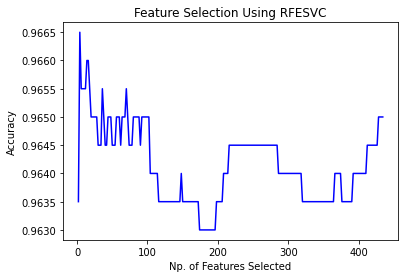

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Fitness = np.load('./Score_r.npy')
Y = []

for i in range(len(Fitness)):
  Y.append((i+1)*2)
plt.plot(Y[::-1],Fitness, color = 'Blue')
#plt.scatter(Y[::-1],Fitness,color = 'Blue')
plt.title('Feature Selection Using RFESVC')
plt.xlabel('Np. of Features Selected')
plt.ylabel('Accuracy')
plt.savefig('./Rfe1.pdf',bbox_inches = 'tight')
plt.show()

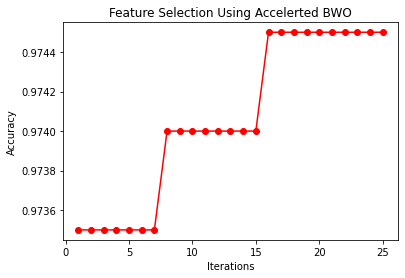

In [6]:
Fit = []
for i in range(0,7):
    Fit.append(0.9735)
for i in range(7,15):
    Fit.append(0.974)
for i in range(15,25):
    Fit.append(0.9745)
plt.scatter(range(1,len(Fit)+1),Fit, color = 'Red')
plt.plot(range(1,len(Fit)+1),Fit, color = 'Red')
#plt.scatter(Y[::-1],Fitness,color = 'Blue')
plt.title('Feature Selection Using Accelerted BWO')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.savefig('./BWO1.pdf',bbox_inches = 'tight')
plt.show()